In [2]:
import numpy as np
import pandas as pd
import tqdm
import pickle
from sympy import plot_implicit, Eq, symbols, exp
import matplotlib.pyplot as plt

%matplotlib inline

# Question 1

## Generate Datas

In [3]:
mu01 = np.array([5,0])
sigma01 = np.array([[4,0], [0,2]])
mu02 = np.array([0,4])
sigma02 = np.array([[1,0], [0,3]])
mu1 = np.array([3,2])
sigma1 = 2 * np.eye(2)

In [4]:
def generate_gmm(mus: list, sigmas: list, weights: list, sample_size = 1000, seed=233):
    """
    Generate samples for Multivariate-GMM
    """
    rs = np.random.RandomState(seed)
    assert len(mus) == len(sigmas)
    assert len(sigmas) == len(weights)
    
    components = np.stack([rs.multivariate_normal(mu, sigma, sample_size) for mu, sigma in zip(mus, sigmas)])
    comp_label = np.random.multinomial(1, weights, sample_size)
    return np.einsum('cnd,nc->nd', components, comp_label)

def generate_q1_dataset(sample_size, seed):
    rs = np.random.RandomState(seed)
    d_0 = generate_gmm([mu01, mu02], [sigma01, sigma02], [0.5,0.5], sample_size)
    d_1 = rs.multivariate_normal(mu1, sigma1, sample_size)
    label = rs.binomial(1, 0.4, (sample_size,1))
    data = d_0 * (1 - label) + d_1 * label
    return (data, label)

Generate $D^{100}_{train}$

In [5]:
train_100, train_label_100 = generate_q1_dataset(100, 100)

Generate $D^{1000}_{train}$

In [6]:
train_1000, train_label_1000 = generate_q1_dataset(1000, 1000)

Generate $D^{10000}_{train}$

In [7]:
train_10000, train_label_10000 = generate_q1_dataset(10000, 10000)

Generate $D^{20K}_{validate}$

In [8]:
validation, validation_label = generate_q1_dataset(20000, 20000)

## Part 1

In [547]:
class Part1Classifier(object):
    def __init__(self, m0s, c0s, weights, m1, c1):
        n = m1.shape[0]
        c0_invs = [np.linalg.inv(c0) for c0 in c0s]
        c1_inv = np.linalg.inv(c1)
        constant0s = [1 / ((2*np.pi)**(n/2) * np.linalg.det(c0) ** (1/2)) for c0 in c0s]
        constant1 = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c1) ** (1/2))
        
        self.cache = (c0s, m0s, c1, m1, c0_invs, c1_inv, constant0s, constant1, weights)
        
    def get_gaussian(self,data, constant, mu, inv_c):
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
        
    def __call__(self, data, gamma):        
        c0s, m0s, c1, m1, c0_invs, c1_inv, constant0s, constant1, weights = self.cache
    
        likelihood1 = self.get_gaussian(data, constant1, m1, c1_inv)
        
        likelihood0 = np.array([self.get_gaussian(data, constant0, m0, c0_inv) 
                                for m0, c0_inv, constant0 in zip(m0s, c0_invs, constant0s)])
        likelihood0 = np.einsum('cn,c->n', likelihood0, weights)
        
        lhs = likelihood1 / likelihood0
        rhs = np.array(gamma)
        return 1 * (lhs[:,np.newaxis] > rhs[np.newaxis,:])

In [253]:
gamma_list = [0, 1e-16, 1e-12, 1e-8, 1e-4] + np.arange(0.0001, 0.001, 0.0001).tolist() + np.arange(0.001, 1, 0.001).tolist() + np.arange(1, 100, 0.01).tolist() + [1e2, 1e4, 1e8, 1e16, 1e64]
test_rule = Part1Classifier([mu01, mu02], [sigma01, sigma02], [0.5,0.5], mu1, sigma1)
validation_pred = test_rule(validation, gamma_list)
theoretical_pred = test_rule(validation, [1.5])

In [256]:
tp_list = ((validation_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
fp_list = ((validation_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
theretical_tp = ((theoretical_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
theretical_fp = ((theoretical_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()

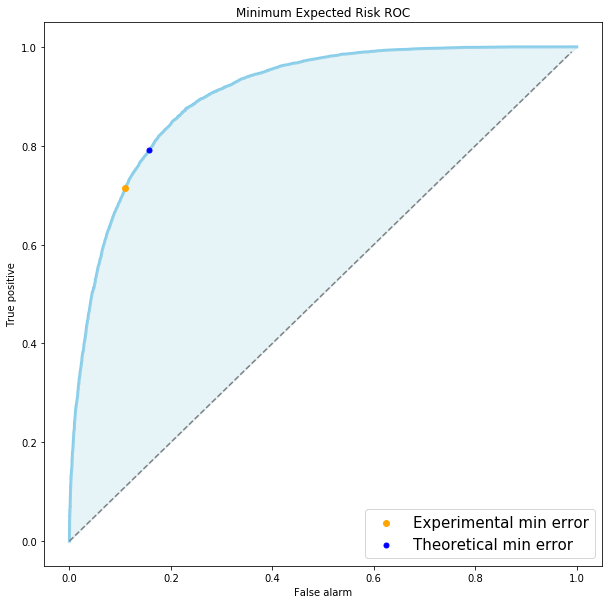

In [262]:
plt.figure(figsize=(10, 10))
plt.plot(fp_list, tp_list, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(fp_list, tp_list, fp_list, color='lightblue', alpha=0.3)
plt.title('Minimum Expected Risk ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin = np.argmin(np.array(fp_list) * 0.7 + np.array(1-tp_list) * 0.3)
plt.scatter(fp_list[argmin], tp_list[argmin], color='orange', zorder=10, s=35,label = 'Experimental min error')
plt.scatter(theretical_fp, theretical_tp, color='blue', zorder=10, s=25,label = 'Theoretical min error')
plt.legend(fontsize=15)

In [491]:
erm_error = (1 - tp_list) * 0.4 + fp_list * 0.6
gamma_list[erm_error.argmin()], erm_error.min()

(1.7200000000000006, 0.17678997076905556)

In [201]:
## Decision Boundary
def plot_classifier_tool(x,y):
    a1 = 1 / (4*np.sqrt(2))
    a2 = 1 / (2*np.sqrt(3))
    a3 = 1 / 3
    return (a1 * np.exp(-0.5*(0.25*(x-5)**2+0.5*y**2)) + 
            a2 * np.exp(-0.5*(x**2+1/3*(y-4)**2)) - 
            a3 * np.exp(-0.25*((x-3)**2+(y-2)**2)))

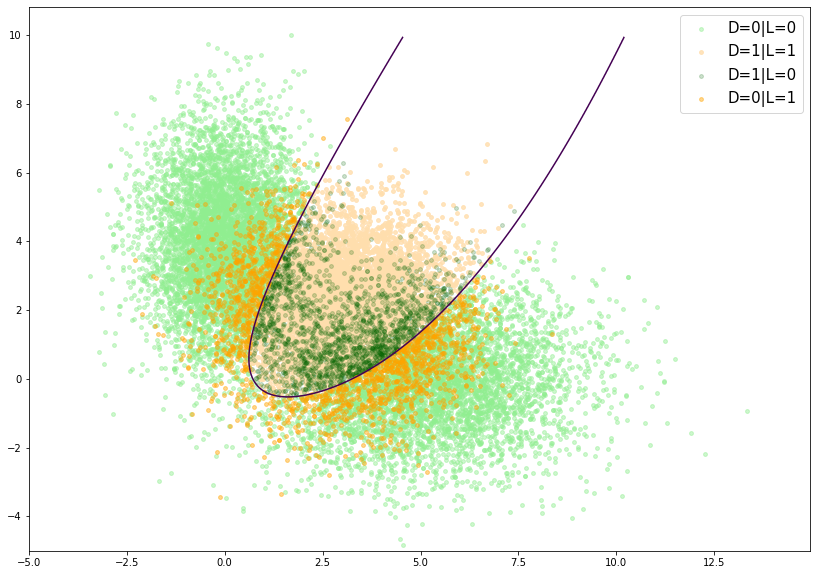

In [251]:
label0T = ((theoretical_pred == 0) & (validation_label == 0)).flatten()
label0F = ((theoretical_pred == 1) & (validation_label == 0)).flatten()
label1T = ((theoretical_pred == 1) & (validation_label == 1)).flatten()
label1F = ((theoretical_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool(X,Y)
plt.contour(X,Y,F,[0])
plt.scatter(validation[label0T][:,0], validation[label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[label1T][:,0], validation[label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[label0F][:,0], validation[label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[label1F][:,0], validation[label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

## Part 2

### GMM+Single_G_MLE

In [550]:
class Part2EM(object):
    def __init__(self, m0s, c0s, weights, m1, c1, priors):
        n = m1.shape[0]
        self.init_cache = (m0s, c0s, weights, m1, c1, priors)
        
    @classmethod
    def get_gaussian(cls, data, mu, c):
        n = mu.shape[0]
        inv_c = np.linalg.inv(c)
        constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
    
    @classmethod
    def calc_expectation_cache(cls, data, current_cache):
        m0s, c0s, weights, m1, c1, priors = current_cache
        
        # Lil: shape [n,2]
        gmm_Ls = [w * cls.get_gaussian(data, m, c) for w,m,c in zip(weights, m0s, c0s)] #[(n,),(n,)]
        Li0 = np.sum(gmm_Ls, axis=0) # shape[n,]
        Li1 = cls.get_gaussian(data, m1, c1) # shape[n,]
        Lil = np.stack([Li0, Li1], axis=-1) # shape [n,2]
        
        # L: shape [n,]
        L = Lil @ priors 
        
        # pil: shape [n,2]
        pil = (Lil * priors) / L[...,np.newaxis]
        
        # wik: shape [n,k]
        wik = (gmm_Ls / Li0).T
        
        return (pil, wik)
    
    @classmethod
    def update_c(cls, data, m, weights):
        part1 = np.einsum('nx,ny->nxy', data - m, data - m)
        return np.einsum('n, nxy->xy', weights, part1) / weights.sum()
    
    @classmethod
    def update(cls, data, current_cache, exp_cache):
        m0s, c0s, weights, m1, c1, priors = current_cache
        pil, wik = exp_cache
        
        pl = pil.mean(axis=0) # shape[2,]
        m1_new = pil[:,1] @ data / pil[:,1].sum() # shape[2,]
        c1_new = cls.update_c(data, m1_new, pil[:,1]) # shape[2,2]
        
        wk = pil[:,0] @ wik / pil[:,0].sum() # [2,]
        m_weight = np.einsum('nk,n->kn', wik, pil[:,0]) # shape[k,n]
        m0s_new = np.einsum('kn,nd->kd', m_weight, data) / m_weight.sum(axis=1) # shape[k,d]
        c0s_new = [cls.update_c(data, mk, wk) for mk,wk in zip(m0s_new, m_weight)]
        return m0s_new, c0s_new, wk, m1_new, c1_new, pl
    
    @classmethod
    def calc_Q(cls, data, current_cache, exp_cache):
        m0s, c0s, weights, m1, c1, priors = current_cache
        pil, wik = exp_cache
        
        # when l = 0
        part_temp = [cls.get_gaussian(data, mk, ck) * wk * priors[0] 
                     for mk,ck,wk in zip(m0s,c0s,weights)]
        log_part = np.log(part_temp)
        m_weight = np.einsum('nk,n->kn', wik, pil[:,0])
        part_0 = (log_part * m_weight).sum()
        
        # when l = 1
        part_1 = (np.log(cls.get_gaussian(data, m1, c1) * priors[1]) * pil[:,1]).sum()
        
        return part_0 + part_1
        
    
    def __call__(self, data, criteria=0.25, max_iter=1000):
        Q_list = list()
        init_exp_cache = self.calc_expectation_cache(data, self.init_cache)
        
        current_cache = self.update(data, self.init_cache, init_exp_cache)
        init_Q = self.calc_Q(data, self.init_cache, init_exp_cache)
        Q_list.append(init_Q)
        i = 0
        while True:
            exp_cache = self.calc_expectation_cache(data, current_cache)
            new_cache = self.update(data, current_cache, exp_cache)
            Q = self.calc_Q(data, new_cache, exp_cache)
            Q_list.append(Q)
            current_cache = new_cache
            i += 1
            
            if np.abs(Q - Q_list[-2]) < criteria:
                break
            if i > max_iter:
                break

        return Q_list, new_cache
    

In [551]:
mu01 = np.array([5,0])
sigma01 = np.array([[4,0], [0,2]])
mu02 = np.array([0,4])
sigma02 = np.array([[1,0], [0,3]])
mu1 = np.array([3,2])
sigma1 = 2 * np.eye(2)

In [552]:
test = Part2EM((mu01, mu02), (sigma01, sigma02), (0.5,0.5), mu1, sigma1, (0.4,0.6))
q_list, new_cache = test(train_10000)
new_cache

(array([[ 5.28457741, -0.08524101],
        [-0.0790495 ,  4.05942834]]), [array([[3.84130651, 0.1305465 ],
         [0.1305465 , 1.9018431 ]]), array([[0.89362319, 0.11847959],
         [0.11847959, 3.01466591]])], array([0.47771802, 0.52228198]), array([2.94110301, 1.90885651]), array([[ 2.38269705, -0.17491205],
        [-0.17491205,  2.14946895]]), array([0.51044665, 0.48955335]))

In [555]:
gamma_list = [0, 1e-16, 1e-12, 1e-8, 1e-4] + np.arange(0.0001, 0.001, 0.0001).tolist() + np.arange(0.001, 1, 0.001).tolist() + np.arange(1, 100, 0.01).tolist() + [1e2, 1e4, 1e8, 1e16, 1e64]

In [565]:
part2_classifier = Part1Classifier(*new_cache[:-1])
validation_pred2 = part2_classifier(validation, gamma_list)
# theoretical_pred = part2_classifier(validation, [1.5])

In [566]:
tp_list2 = ((validation_pred2 == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
fp_list2 = ((validation_pred2 == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
# theretical_tp = ((theoretical_pred2 == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
# theretical_fp = ((theoretical_pred2 == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()

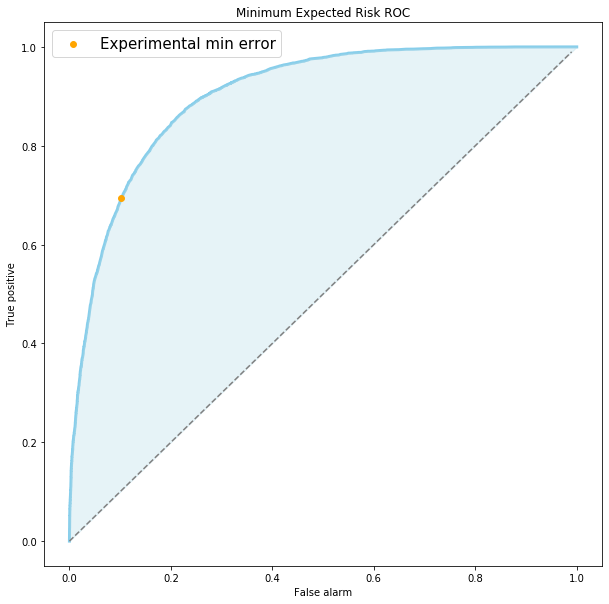

In [567]:
plt.figure(figsize=(10, 10))
plt.plot(fp_list2, tp_list2, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(fp_list2, tp_list2, fp_list2, color='lightblue', alpha=0.3)
plt.title('Minimum Expected Risk ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin = np.argmin(np.array(fp_list2) * 0.7 + np.array(1-tp_list2) * 0.3)
plt.scatter(fp_list2[argmin], tp_list2[argmin], color='orange', zorder=10, s=35,label = 'Experimental min error')
# plt.scatter(theretical_fp, theretical_tp, color='blue', zorder=10, s=25,label = 'Theoretical min error')
plt.legend(fontsize=15)

In [568]:
erm_error2 = (1 - tp_list2) * new_cache[-1][1] + fp_list2 * new_cache[-1][0]
gamma_list[erm_error2.argmin()], erm_error2.min()

(1.3300000000000003, 0.17775129550234708)

In [553]:
# train_1000
q_list_1000, new_cache_1000 = test(train_1000)
new_cache_1000

(array([[ 5.31497365, -0.09344289],
        [-0.01129646,  4.16226188]]), [array([[3.07746373, 0.38560425],
         [0.38560425, 1.61411854]]), array([[ 9.58075394e-01, -3.50883303e-04],
         [-3.50883303e-04,  3.25717479e+00]])], array([0.46004538, 0.53995462]), array([2.81785456, 1.97487471]), array([[2.50075725, 0.07903947],
        [0.07903947, 2.03971594]]), array([0.52905248, 0.47094752]))

In [556]:
part2_classifier_1000 = Part1Classifier(*new_cache_1000[:-1])
validation_pred_1000 = part2_classifier_1000(validation, gamma_list)

In [557]:
tp_list_1000 = ((validation_pred_1000 == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
fp_list_1000 = ((validation_pred_1000 == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()

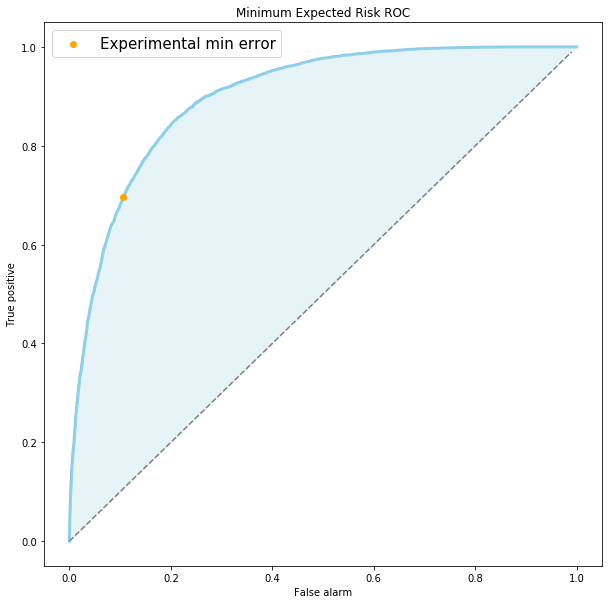

In [558]:
plt.figure(figsize=(10, 10))
plt.plot(fp_list_1000, tp_list_1000, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(fp_list_1000, tp_list_1000, fp_list_1000, color='lightblue', alpha=0.3)
plt.title('Minimum Expected Risk ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin = np.argmin(np.array(fp_list_1000) * 0.7 + np.array(1-tp_list_1000) * 0.3)
plt.scatter(fp_list_1000[argmin], tp_list_1000[argmin], color='orange', zorder=10, s=35,label = 'Experimental min error')
# plt.scatter(theretical_fp, theretical_tp, color='blue', zorder=10, s=25,label = 'Theoretical min error')
plt.legend(fontsize=15)

In [559]:
erm_error_1000 = (1 - tp_list_1000) * new_cache_1000[-1][1] + fp_list_1000 * new_cache_1000[-1][0]
gamma_list[erm_error_1000.argmin()], erm_error_1000.min()

(1.2600000000000002, 0.17978808768373905)

In [560]:
#train_100
q_list_100, new_cache_100 = test(train_100)
new_cache_100

(array([[ 5.76606916,  0.08935795],
        [-0.05067276,  4.15988946]]), [array([[3.83411923, 1.72623008],
         [1.72623008, 2.79291652]]), array([[ 0.64212751, -0.21894078],
         [-0.21894078,  1.96314653]])], array([0.47813063, 0.52186937]), array([2.77818039, 1.40235701]), array([[2.36906755, 0.6443158 ],
        [0.6443158 , 2.34137331]]), array([0.52611786, 0.47388214]))

In [561]:
part2_classifier_100 = Part1Classifier(*new_cache_100[:-1])
validation_pred_100 = part2_classifier_100(validation, gamma_list)

In [562]:
tp_list_100 = ((validation_pred_100 == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
fp_list_100 = ((validation_pred_100 == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()

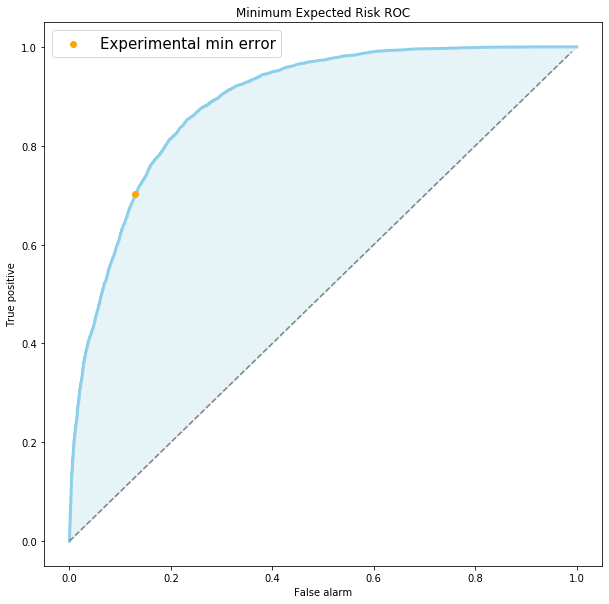

In [563]:
plt.figure(figsize=(10, 10))
plt.plot(fp_list_100, tp_list_100, color='skyblue', linewidth=3, zorder=0)
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), '--', color='grey')
plt.fill_between(fp_list_100, tp_list_100, fp_list_100, color='lightblue', alpha=0.3)
plt.title('Minimum Expected Risk ROC')
plt.xlabel('False alarm')
plt.ylabel('True positive')
argmin = np.argmin(np.array(fp_list_100) * 0.7 + np.array(1- tp_list_100) * 0.3)
plt.scatter(fp_list_100[argmin], tp_list_100[argmin], color='orange', zorder=10, s=35,label = 'Experimental min error')
# plt.scatter(theretical_fp, theretical_tp, color='blue', zorder=10, s=25,label = 'Theoretical min error')
plt.legend(fontsize=15)

In [564]:
erm_error_100 = (1 - tp_list_100) * new_cache_100[-1][1] + fp_list_100 * new_cache_100[-1][0]
gamma_list[erm_error_100.argmin()], erm_error_100.min()

(1.3600000000000003, 0.19175771885429166)

### Single Gaussian MLE

In [283]:
def get_gaussian_MLE_parameters(data):
    n = data.shape[0]
    m_new = np.mean(data, axis = 0)
    part1 = data - m_new #[n,2]
    c_new = np.einsum('nx,yn -> xy', part1, part1.T)
    return m_new, c_new

In [284]:
rs = np.random.RandomState(223)
d1 = rs.multivariate_normal(mu1, sigma1, 100000)

In [285]:
get_gaussian_MLE_parameters(d1)

(array([3.00196672, 1.99649011]), array([[201327.42904877,    527.92724486],
        [   527.92724486, 199917.62247327]]))

### GMM_MLE

In [15]:
class GMM_MLE(object):
    def __init__(self, m0s, c0s, weights):
        self.init_cache = (m0s, c0s, weights)
        
    @classmethod
    def get_gaussian(cls, data, mu, c):
        n = mu.shape[0]
        inv_c = np.linalg.inv(c)
        constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return constant * np.exp(-0.5 * power)
    
    @classmethod
    def get_log_gaussian(cls, data, mu, c):
        n = mu.shape[0]
        inv_c = np.linalg.inv(c)
        constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
        part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
        power = np.einsum('ny, ny -> n', part1, data - mu.T)
        return np.log(constant) - 0.5 * power
    
    @classmethod
    def calc_expectation_cache(cls, data, current_cache):
        m0s, c0s, weights = current_cache
        
        # Li0: shape [n,]
        gmm_Ls = [w * cls.get_gaussian(data, m, c) for w,m,c in zip(weights, m0s, c0s)]
        Li0 = np.sum(gmm_Ls, axis=0)
        
        # wik: shape [n,k]
        wik = (gmm_Ls / Li0).T
        
        return wik
    
    @classmethod
    def update_c(cls, data, m, weights):
        part1 = np.einsum('nx,ny->nxy', data - m, data - m)
        return np.einsum('n, nxy->xy', weights, part1) / weights.sum() 
    
    @classmethod
    def update(cls, data, current_cache, exp_cache):
        m0s, c0s, weights = current_cache
        wik = exp_cache
         
        pk = wik.sum(axis=0) / wik.shape[0] 
        m_weight = wik.T # [k,n]
        m0s_new = np.einsum('nk,nd -> kd', wik, data) / np.sum(wik,axis=0)[...,np.newaxis] #[k,d]
        c0s_new = [cls.update_c(data, mk, wk) for mk,wk in zip(m0s_new, m_weight)] 
        return m0s_new, c0s_new, pk
    
    @classmethod
    def calc_Q(cls, data, current_cache, exp_cache):
        m0s, c0s, weights = current_cache
        wik = exp_cache
        
        #part_temp = [cls.get_gaussian(data, mk, ck) * wk 
        #             for mk,ck,wk in zip(m0s,c0s,weights)]
        #print(part_temp)
        log_part = [cls.get_log_gaussian(data, mk, ck) * wk 
                    for mk,ck,wk in zip(m0s,c0s,weights)]
        print(log_part)
        m_weight = wik.T #[k,n]
        part_0 = (log_part * m_weight).sum()
        return part_0 
        
    def __call__(self, data, criteria=0.25, max_iter=1000):
        Q_list = list()
        init_exp_cache = self.calc_expectation_cache(data, self.init_cache)
        current_cache = self.update(data, self.init_cache, init_exp_cache)
        
        init_Q = self.calc_Q(data, self.init_cache, init_exp_cache)
        Q_list.append(init_Q)
        i = 0
        while True:
            exp_cache = self.calc_expectation_cache(data, current_cache)
            new_cache = self.update(data, current_cache, exp_cache)
            Q = self.calc_Q(data, new_cache, exp_cache)
            Q_list.append(Q)
            current_cache = new_cache
            i += 1
            
            if np.abs(Q - Q_list[-2]) < criteria:
                break
            if i > max_iter:
                break

        return Q_list, new_cache

In [13]:
mu01 = np.array([5,0])
sigma01 = np.array([[4,0], [0,2]])
mu02 = np.array([0,4])
sigma02 = np.array([[1,0], [0,3]])

mu03 = np.array([0,3])
sigma03 = np.array([[1,0], [0,3]])
mu04 = np.array([0,2])
sigma04 = np.array([[2,0], [0,2]])

In [14]:
d = validation[validation_label[:,0] == 0]

In [15]:
test = GMM_MLE((mu01, mu02), (sigma01, sigma02), (0.50,0.50))
q_list, new_cache = test(d)
q_list, new_cache

[array([-1.64140529, -1.70623722, -2.00185141, ..., -4.45514656,
       -3.45384034, -2.64152742]), array([-13.79326938,  -5.34147046,  -9.72034869, ...,  -1.80108466,
        -2.13198604, -12.27383281])]
[array([-1.63108227, -1.69148183, -1.96795899, ..., -4.41438892,
       -3.42194628, -2.58405969]), array([-14.157657  ,  -5.4377568 ,  -9.97722295, ...,  -1.82255954,
        -2.16178972, -12.61491893])]
[array([-1.63135051, -1.69163794, -1.96817363, ..., -4.41411556,
       -3.42176839, -2.58434087]), array([-14.1633481 ,  -5.44001743,  -9.98065177, ...,  -1.82254845,
        -2.16206693, -12.6187879 ])]
[array([-1.63154233, -1.69174075, -1.96834649, ..., -4.4138056 ,
       -3.42155261, -2.58457752]), array([-14.16541396,  -5.4409901 ,  -9.9818009 , ...,  -1.82248269,
        -2.16212938, -12.61997241])]


([-21714.666845060456,
  -21698.77918287183,
  -21698.48731097021,
  -21698.577681168328],
 (array([[ 4.98552972e+00,  2.46676649e-02],
         [-1.19889444e-03,  3.99284265e+00]]),
  [array([[4.01019494, 0.05114892],
          [0.05114892, 2.02017113]]),
   array([[ 9.77344610e-01, -1.03864490e-03],
          [-1.03864490e-03,  2.97272756e+00]])],
  array([0.49611269, 0.50388731])))

In [345]:
test1 = GMM_MLE([np.array([3*x,5*y]) for x,y in zip(np.arange(-4,4,8/16), np.arange(-4,4,8/16))], 
                [np.eye(2) * r for r in np.arange(1,16+1)/4], 
                [1/16] * 16)
q_list1, new_cache1 = test1(train_100_q2)
q_list1, new_cache1

([-24.978579428925258,
  -22.128897545184277,
  -21.434524450718392,
  -20.9041741786638,
  -20.574526713529103,
  -20.27842792263001,
  -19.736772632706007,
  -19.11477805784019,
  -18.84227357652164,
  -18.741104331869806],
 (array([[-12.62706873, -20.06036679],
         [ -8.71239863, -19.32878409],
         [ -9.87956751, -14.85250484],
         [ -8.57917345, -12.8269887 ],
         [ -5.58725841,  -9.38255835],
         [ -3.56577326,  -7.93450004],
         [ -4.11541307,  -6.56231636],
         [ -0.90070511,  -2.94931003],
         [ -1.18375854,  -0.2368687 ],
         [  0.98112762,   1.65133591],
         [  2.69940657,   5.05294424],
         [  3.79619264,   6.95312738],
         [  5.81626513,   9.31662004],
         [  7.25484455,  12.73560498],
         [  8.76835349,  14.97263743],
         [  9.79319738,  16.27549156]]), [array([[0.46698907, 0.3517928 ],
          [0.3517928 , 0.27448101]]), array([[ 1.59907977, -0.20686037],
          [-0.20686037,  2.09469198]]), a

## Part 3

In [8]:
class Part3Model(object):
    
    def __init__(self, d, learning_rate = 0.001, mode = 'linear'):
        """
        d: dimension of original data
        """
        self.mode = mode
        self.learning_rate = learning_rate
        
        if self.mode == 'linear':
            self.weight = np.random.rand(d + 1)
        elif self.mode == 'quadratic':
            self.weight = np.random.rand(d**2 + d)
        else:
            raise ValueError('unknown mode: ' + mode)
        
    @classmethod
    def calc_linear_z(cls, data):
        return np.insert(data, 0, 1, axis=1)
    
    @classmethod
    def calc_quadratic_z(cls, data):
        linear_z = cls.calc_linear_z(data)
        tu_idx = np.triu_indices(linear_z.shape[-1])
        quadratic_z = np.einsum('nx,ny->nxy',linear_z,linear_z)
        quadratic_z = quadratic_z[...,tu_idx[0], tu_idx[1]]
        return quadratic_z
    
    @classmethod
    def sigmoid(cls, weight, z):
        part1 = np.exp(- np.einsum('z,nz->n', weight, z))
        return 1 / (1 + part1)
    
    @classmethod
    def gradient(cls, label, prob, z):
        return - np.einsum('n,nz->z', label - prob, z) / z.shape[1]
    
    def train(self, data, label, max_iter = 1000, epsilon = 0.001):
        if self.mode == 'linear':
            z = self.calc_linear_z(data)
        elif self.mode == 'quadratic':
            z = self.calc_quadratic_z(data)
        else:
            raise ValueError('unknown mode: ' + mode)
            
        i = 0
        iterator = tqdm.tqdm(range(max_iter))
        for i in iterator:
            i += 1
            prob = self.sigmoid(self.weight, z)
            gradient = self.gradient(label, prob, z)
            self.weight = self.weight - self.learning_rate * gradient
            if np.linalg.norm(gradient) < epsilon:
                iterator.close()
                break
    
    def __call__(self, data):
        if self.mode == 'linear':
            z = self.calc_linear_z(data)
        elif self.mode == 'quadratic':
            z = self.calc_quadratic_z(data)
        else:
            raise ValueError('unknown mode: ' + mode)
            
        return self.sigmoid(self.weight, z)

In [9]:
## Decision Boundary
def plot_classifier_tool_partc(x, y, weights, mode='linear'):
    xy = np.stack([x.flatten(), y.flatten()], axis=-1)
    if mode == 'linear':
        z = Part3Model.calc_linear_z(xy)
        result = - z @ weights
        return result.reshape(x.shape)
    elif mode == 'quadratic':
        z = Part3Model.calc_quadratic_z(xy)
        result = - z @ weights
        return result.reshape(x.shape)
    else:
        raise ValueError('unknown mode: ' + mode)

### logistic-linear 

In [90]:
# logistic-linear 
test_rule_lin_100 = Part3Model(2, 0.0001, 'linear')

In [91]:
## train_100
test_rule_lin_100.train(train_100, train_label_100[:,0], 50000)

 80%|███████▉  | 39870/50000 [00:01<00:00, 40631.59it/s]


In [92]:
train_100_lin_pred = ((test_rule_lin_100(validation) > 0.5)*1)[:, np.newaxis]

In [93]:
test_rule_lin_100.weight

array([-0.6460887 ,  0.06269179, -0.01064261])

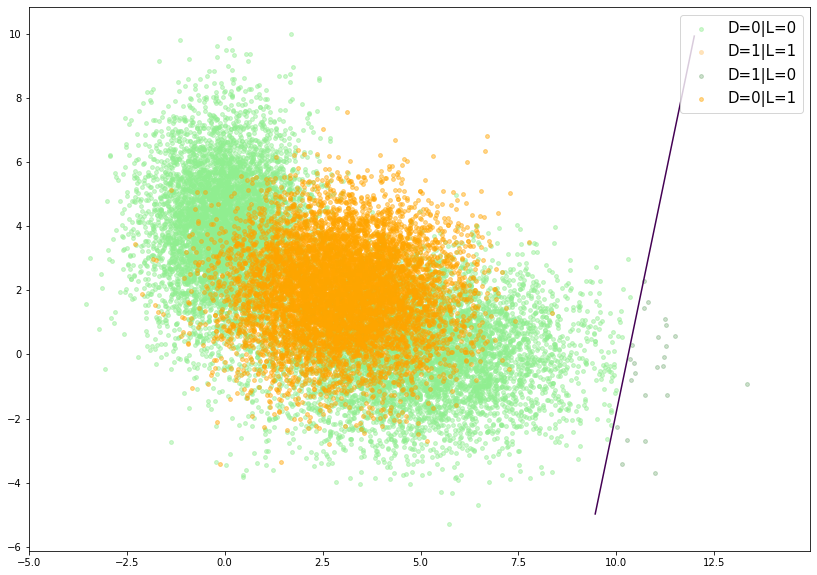

In [94]:
train_100_lin_label0T = ((train_100_lin_pred == 0) & (validation_label == 0)).flatten()
train_100_lin_label0F = ((train_100_lin_pred == 1) & (validation_label == 0)).flatten()
train_100_lin_label1T = ((train_100_lin_pred == 1) & (validation_label == 1)).flatten()
train_100_lin_label1F = ((train_100_lin_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_lin_100.weight, 'linear')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_100_lin_label0T][:,0], validation[train_100_lin_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_100_lin_label1T][:,0], validation[train_100_lin_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_100_lin_label0F][:,0], validation[train_100_lin_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_100_lin_label1F][:,0], validation[train_100_lin_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [95]:
train_100_lin_tp = ((train_100_lin_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_100_lin_fp = ((train_100_lin_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_100_lin_error = (1 - train_100_lin_tp) * 0.4 + train_100_lin_fp * 0.6
train_100_lin_error

array([0.4012024])

In [99]:
# train_1000
test_rule_lin_1000 = Part3Model(2, 0.0001, 'linear')

In [100]:
test_rule_lin_1000.train(train_1000, train_label_1000[:,0],10000)

 63%|██████▎   | 6312/10000 [00:00<00:00, 20944.68it/s]


In [101]:
train_1000_lin_pred = ((test_rule_lin_1000(validation) > 0.5)*1)[:, np.newaxis]

In [102]:
test_rule_lin_1000.weight

array([-0.93847516,  0.11613197,  0.0764085 ])

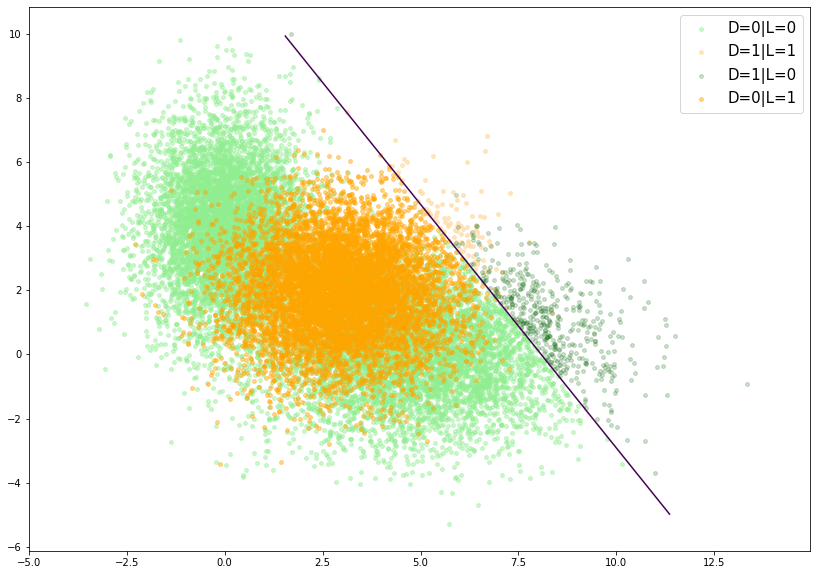

In [103]:
train_1000_lin_label0T = ((train_1000_lin_pred == 0) & (validation_label == 0)).flatten()
train_1000_lin_label0F = ((train_1000_lin_pred == 1) & (validation_label == 0)).flatten()
train_1000_lin_label1T = ((train_1000_lin_pred == 1) & (validation_label == 1)).flatten()
train_1000_lin_label1F = ((train_1000_lin_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_lin_1000.weight, 'linear')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_1000_lin_label0T][:,0], validation[train_1000_lin_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_1000_lin_label1T][:,0], validation[train_1000_lin_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_1000_lin_label0F][:,0], validation[train_1000_lin_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_1000_lin_label1F][:,0], validation[train_1000_lin_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [104]:
train_1000_lin_tp = ((train_1000_lin_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_1000_lin_fp = ((train_1000_lin_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_1000_lin_error = (1 - train_1000_lin_tp) * 0.4 + train_1000_lin_fp * 0.6
train_1000_lin_error

array([0.41811165])

In [105]:
# train_10000
test_rule_lin_10000 = Part3Model(2, 0.00001, 'linear')

In [106]:
test_rule_lin_10000.train(train_10000, train_label_10000[:,0],10000)
train_10000_lin_pred = ((test_rule_lin_10000(validation) > 0.5)*1)[:, np.newaxis]

 88%|████████▊ | 8810/10000 [00:01<00:00, 5794.03it/s]


In [107]:
test_rule_lin_10000.weight

array([-0.8754836 ,  0.11741393,  0.08730371])

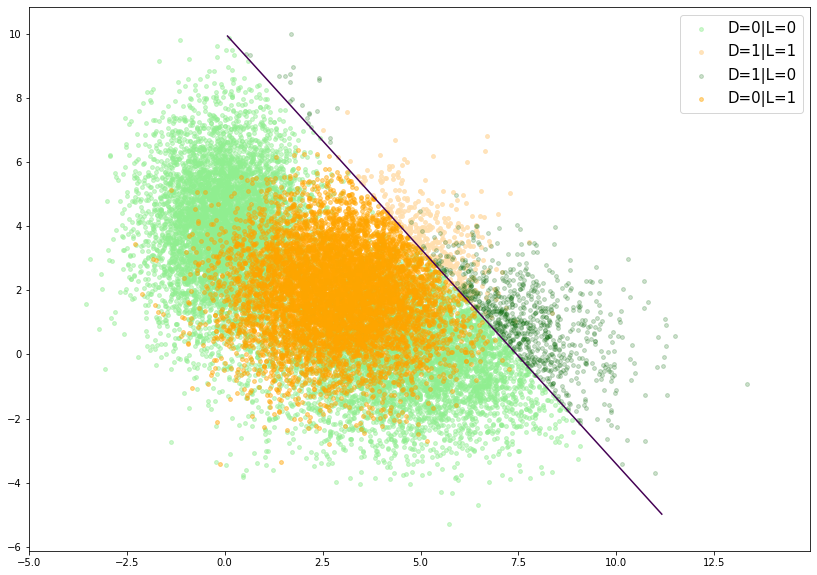

In [108]:
train_10000_lin_label0T = ((train_10000_lin_pred == 0) & (validation_label == 0)).flatten()
train_10000_lin_label0F = ((train_10000_lin_pred == 1) & (validation_label == 0)).flatten()
train_10000_lin_label1T = ((train_10000_lin_pred == 1) & (validation_label == 1)).flatten()
train_10000_lin_label1F = ((train_10000_lin_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_lin_10000.weight, 'linear')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_10000_lin_label0T][:,0], validation[train_10000_lin_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_10000_lin_label1T][:,0], validation[train_10000_lin_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_10000_lin_label0F][:,0], validation[train_10000_lin_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_10000_lin_label1F][:,0], validation[train_10000_lin_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [109]:
train_10000_lin_tp = ((train_10000_lin_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_10000_lin_fp = ((train_10000_lin_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_10000_lin_error = (1 - train_10000_lin_tp) * 0.4 + train_10000_lin_fp * 0.6
train_10000_lin_error

array([0.42463801])

### logistic-quadratic

In [10]:
test_rule_qua_100 = Part3Model(2, 0.001, 'quadratic')

In [11]:
## train_100
test_rule_qua_100.train(train_100, train_label_100[:,0], 1000000)
train_100_qua_pred = ((test_rule_qua_100(validation) > 0.5)*1)[:, np.newaxis]

  6%|▌         | 57850/1000000 [00:01<00:19, 47323.29it/s]


In [12]:
test_rule_qua_100.weight

array([-1.89452207,  1.83785399,  0.75676486, -0.34128929,  0.22482906,
       -0.28584848])

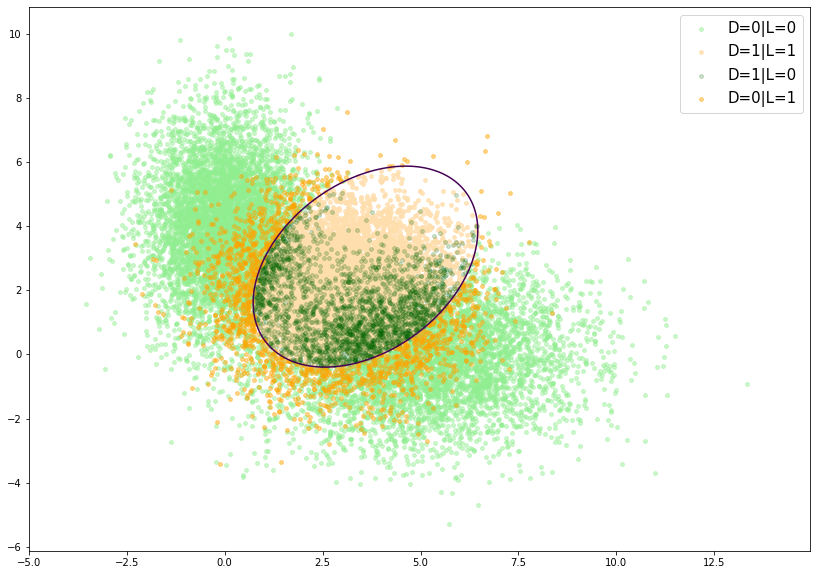

In [13]:
train_100_qua_label0T = ((train_100_qua_pred == 0) & (validation_label == 0)).flatten()
train_100_qua_label0F = ((train_100_qua_pred == 1) & (validation_label == 0)).flatten()
train_100_qua_label1T = ((train_100_qua_pred == 1) & (validation_label == 1)).flatten()
train_100_qua_label1F = ((train_100_qua_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_qua_100.weight, 'quadratic')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_100_qua_label0T][:,0], validation[train_100_qua_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_100_qua_label1T][:,0], validation[train_100_qua_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_100_qua_label0F][:,0], validation[train_100_qua_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_100_qua_label1F][:,0], validation[train_100_qua_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [14]:
train_100_qua_tp = ((train_100_qua_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_100_qua_fp = ((train_100_qua_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_100_qua_error = (1 - train_100_qua_tp) * 0.4 + train_100_qua_fp * 0.6
train_100_qua_error

array([0.18555696])

In [19]:
test_rule_qua_1000 = Part3Model(2, 0.0001, 'quadratic')

In [20]:
## train_1000
test_rule_qua_1000.train(train_1000, train_label_1000[:,0], 100000)
train_1000_qua_pred = ((test_rule_qua_1000(validation) > 0.5)*1)[:, np.newaxis]

 66%|██████▌   | 66033/100000 [00:02<00:01, 31028.30it/s]


In [21]:
test_rule_qua_1000.weight

array([-0.92081131,  1.35718252,  0.08329065, -0.32555967,  0.36660339,
       -0.17972399])

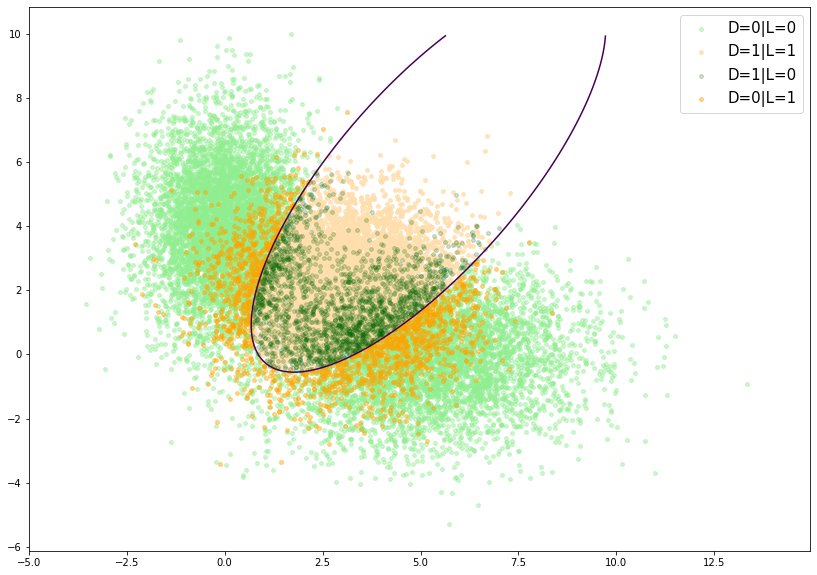

In [22]:
train_1000_qua_label0T = ((train_1000_qua_pred == 0) & (validation_label == 0)).flatten()
train_1000_qua_label0F = ((train_1000_qua_pred == 1) & (validation_label == 0)).flatten()
train_1000_qua_label1T = ((train_1000_qua_pred == 1) & (validation_label == 1)).flatten()
train_1000_qua_label1F = ((train_1000_qua_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_qua_1000.weight, 'quadratic')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_1000_qua_label0T][:,0], validation[train_1000_qua_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_1000_qua_label1T][:,0], validation[train_1000_qua_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_1000_qua_label0F][:,0], validation[train_1000_qua_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_1000_qua_label1F][:,0], validation[train_1000_qua_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [23]:
train_1000_qua_tp = ((train_1000_qua_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_1000_qua_fp = ((train_1000_qua_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_1000_qua_error = (1 - train_1000_qua_tp) * 0.4 + train_1000_qua_fp * 0.6
train_1000_qua_error

array([0.17920937])

In [35]:
test_rule_qua_10000 = Part3Model(2, 0.00001, 'quadratic')

In [36]:
## train_10000
test_rule_qua_10000.train(train_10000, train_label_10000[:,0], 100000, 0.001)
train_10000_qua_pred = ((test_rule_qua_10000(validation) > 0.5)*1)[:, np.newaxis]


 82%|████████▏ | 81928/100000 [00:09<00:02, 8817.70it/s]


In [37]:
test_rule_qua_10000.weight

array([-0.92334449,  1.2886518 ,  0.10267532, -0.28481299,  0.29778657,
       -0.15251868])

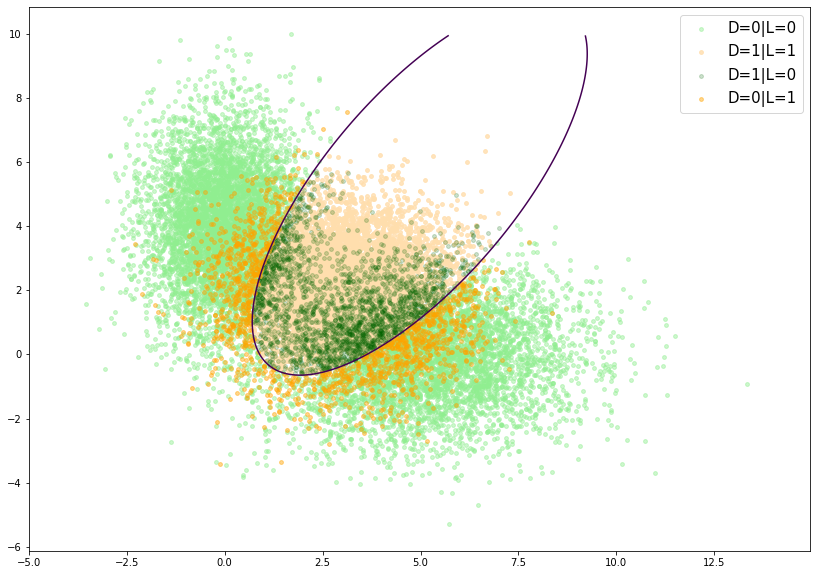

In [38]:
train_10000_qua_label0T = ((train_10000_qua_pred == 0) & (validation_label == 0)).flatten()
train_10000_qua_label0F = ((train_10000_qua_pred == 1) & (validation_label == 0)).flatten()
train_10000_qua_label1T = ((train_10000_qua_pred == 1) & (validation_label == 1)).flatten()
train_10000_qua_label1F = ((train_10000_qua_pred == 0) & (validation_label == 1)).flatten()

plt.figure(figsize=(14,10))
xrange = np.arange(-5.0, 15.0, 0.05)
yrange = np.arange(-5.0, 10.0, 0.05)
X, Y = np.meshgrid(xrange,yrange)
F = plot_classifier_tool_partc(X,Y, test_rule_qua_10000.weight, 'quadratic')
plt.contour(X,Y,F,[0])
plt.scatter(validation[train_10000_qua_label0T][:,0], validation[train_10000_qua_label0T][:,1], color='lightgreen', s=15, alpha=0.45, label='D=0|L=0')
plt.scatter(validation[train_10000_qua_label1T][:,0], validation[train_10000_qua_label1T][:,1], color='navajowhite', s=15, alpha=0.8, label='D=1|L=1')
plt.scatter(validation[train_10000_qua_label0F][:,0], validation[train_10000_qua_label0F][:,1], color='darkgreen', s=15, alpha=0.2, label='D=1|L=0')
plt.scatter(validation[train_10000_qua_label1F][:,0], validation[train_10000_qua_label1F][:,1], color='orange', s=15, alpha=0.45, label='D=0|L=1')
plt.legend(fontsize=15)

In [39]:
train_10000_qua_tp = ((train_10000_qua_pred == 1) & (validation_label == 1)).sum(axis=0) / validation_label.sum()
train_10000_qua_fp = ((train_10000_qua_pred == 1) & (validation_label == 0)).sum(axis=0) / (validation_label == 0).sum()
train_10000_qua_error = (1 - train_10000_qua_tp) * 0.4 + train_10000_qua_fp * 0.6
train_10000_qua_error

array([0.18060728])

# Question2

## Generate data

In [9]:
Mus_list = [np.array([3*x,5*y]) for x,y in zip(np.arange(-4,4,0.5), np.arange(-4,4,0.5))]
Sigma_list = [np.eye(2) * r for r in np.arange(1,len(Mus_list)+1)/4]
np.random.shuffle(Sigma_list)
weights_list = np.array([1/len(Mus_list)]*len(Mus_list))

In [10]:
train_100_q2 = generate_gmm(Mus_list, Sigma_list, weights_list, sample_size = 100, seed=233)

In [11]:
train_1000_q2 = generate_gmm(Mus_list, Sigma_list, weights_list, sample_size = 1000, seed=233)

In [12]:
train_10000_q2 = generate_gmm(Mus_list, Sigma_list, weights_list, sample_size = 10000, seed=233)

In [13]:
train_100000_q2 = generate_gmm(Mus_list, Sigma_list, weights_list, sample_size = 100000, seed=233)

Text(0.5, 1.0, 'data distribution for train_100000')

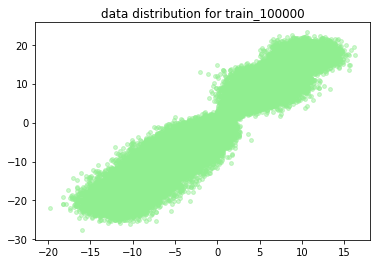

In [569]:
plt.scatter(train_100000_q2[:,0], train_100000_q2[:,1], color='lightgreen', s=15, alpha=0.45)
plt.title('data distribution for train_100000')

## BIC

In [16]:
class GMM_EM_M(GMM_MLE):
    def __init__(self, m):
        def rdm():
            c = np.random.rand(1)[0] * 0.05 + 0.95
            # print(c)
            return c
        
        mus = [np.array([3*x,5*y]) * rdm() for x,y in zip(np.arange(-4,4,8/m), np.arange(-4,4,8/m))]
        sigmas = [np.eye(2) * r * rdm() for r in np.arange(1,m+1)/4]
        weights = [1/m] * m
        super(GMM_EM_M, self).__init__(mus, sigmas, weights)
        
    def train(self, data, criteria=0.25, max_iter=1000):
        return super(GMM_EM_M, self).__call__(data, criteria=criteria, max_iter=max_iter)
    
    def __call__(self, data, current_cache, bic=True):
        m0s, c0s, weights = current_cache
        
        # Li0: shape [n,]
        gmm_Ls = [w * self.get_gaussian(data, m, c) for w,m,c in zip(weights, m0s, c0s)]
        Li0 = np.sum(gmm_Ls, axis=0)
        likelihood = np.log(Li0).sum()
        
        if bic:
            k = (np.prod(m0s[0].shape) + 
                 np.prod(np.triu_indices(c0s[0].shape[0])[0].shape) 
                 + 1)
            k *= len(m0s)
            result = -2 * likelihood + k * np.log(data.shape[0])
        else:
            result = likelihood
        
        return result

In [18]:
def rdm():
    c = np.random.rand(1)[0] * 0.05 + 0.95
    # print(c)
    return c

In [24]:
mus = [np.array([3*x,5*y]) * rdm() for x,y in zip(np.arange(-4,4,8/4), np.arange(-4,4,8/4))]
sigmas = [np.eye(2) * r * rdm() for r in np.arange(1,4+1)/4]
weights = [1/4] * 4

In [26]:
def get_gaussian(data, mu, c):
    n = mu.shape[0]
    inv_c = np.linalg.inv(c)
    constant = 1 / ((2*np.pi)**(n/2) * np.linalg.det(c) ** (1/2))
        
    part1 = np.einsum('nx, xy -> ny', data - mu.T, inv_c)
    power = np.einsum('ny, ny -> n', part1, data - mu.T)
    return constant * np.exp(-0.5 * power)

In [27]:
gmm_Ls = [w * get_gaussian(train_100_q2, m, c) for w,m,c in zip(weights, mus, sigmas)]
Li0 = np.sum(gmm_Ls, axis=0)
likelihood = np.log(Li0).sum()

In [29]:
Li0

array([1.34963914e-02, 1.98402688e-03, 4.58239438e-05, 1.89172424e-08,
       2.69539802e-17, 3.24401754e-11, 5.84439792e-04, 1.72467769e-02,
       1.87545648e-29, 1.07529099e-19, 9.93447376e-09, 5.29951521e-09,
       3.95984201e-03, 2.00855942e-08, 9.10639604e-03, 2.45820622e-04,
       4.00049475e-10, 6.16767586e-03, 5.41054231e-18, 3.45978689e-02,
       4.27472527e-02, 4.50659970e-14, 5.13701494e-02, 4.41751954e-04,
       3.44750125e-04, 2.92740945e-12, 1.32831878e-07, 7.90357836e-02,
       5.48904834e-03, 1.67418445e-02, 7.30676650e-05, 4.19482669e-26,
       1.12961834e-09, 7.54091616e-08, 3.94203062e-02, 6.13838464e-10,
       4.04257109e-04, 5.46997898e-05, 2.25053760e-05, 2.60185304e-18,
       3.37752094e-05, 4.21185177e-37, 1.09451387e-15, 2.05976122e-11,
       1.28312524e-04, 3.38822777e-09, 2.95703557e-20, 2.93305379e-02,
       5.52166162e-06, 1.58149492e-20, 9.65880534e-08, 2.73864630e-06,
       3.85742917e-11, 1.59564828e-02, 4.30486102e-04, 3.69394372e-07,
      

In [471]:
def one_epoch_test():
    biclist = []
    em_100 = GMM_EM_M(1)
    # m = 1
    m, c = get_gaussian_MLE_parameters(train_100_q2)
    biclist.append(em_100(train_100_q2, [[m],[c],[1]]))
    # m = 2:20
    for m in range(2,21):
        em_100 = GMM_EM_M(m)
        a,b = em_100.train(train_100_q2)
        biclist.append(em_100(train_100_q2,b))
    return biclist

In [528]:
!python test.py

Size 100 begin training ...... DONE! (0.27 mins)
Size 100 begin stroing ...... DONE!
Size 1000 begin training ...... DONE! (0.09 mins)
Size 1000 begin stroing ...... DONE!
Size 10000 begin training ...... DONE! (2.44 mins)
Size 10000 begin stroing ...... DONE!
Size 100000 begin training ...... DONE! (68.12 mins)
Size 100000 begin stroing ...... DONE!
Size 1000000 begin training ...... DONE! (1785.04 mins)
Size 1000000 begin stroing ...... DONE!


In [407]:
!ls test_result

1000_result.pkl 100_result.pkl


In [534]:
#First 10 times experiments
with open('test_result/100_result.pkl', 'rb') as f:
    result_100 = pickle.load(f)

In [ ]:
with open('test_result/100_result.pkl', 'rb') as f:
    result_100 = pickle.load(f)

In [535]:
with open('test_result/1000_result.pkl', 'rb') as a:
    result_1000 = pickle.load(a)

In [536]:
with open('test_result/10000_result.pkl', 'rb') as b:
    result_10000 = pickle.load(b)

In [537]:
with open('test_result/100000_result.pkl', 'rb') as c:
    result_100000 = pickle.load(c)

In [538]:
with open('test_result/1000000_result.pkl', 'rb') as d:
    result_1000000 = pickle.load(d)

In [734]:
#second 20 times experiments
with open('100_result.pkl', 'rb') as p:
    result_100_test = pickle.load(p)

In [804]:
with open('1000_result.pkl', 'rb') as e:
    result_1000_test = pickle.load(e)

In [820]:
with open('10000_result.pkl', 'rb') as r:
    result_10000_test = pickle.load(r)

In [805]:
with open('100000_result.pkl', 'rb') as t:
    result_100000_test = pickle.load(t)

In [806]:
with open('1000000_result.pkl', 'rb') as y:
    result_1000000_test = pickle.load(y)

In [807]:
MinBIC_experiment_100 = []
for i in range(0,20):
    MinBIC_experiment_100.append(np.nanargmin(np.array(result_100_test[i])))

In [812]:
BICComponentSelect_100 = MinBIC_experiment_100 + MinBIC_experiment_list_100

In [813]:
BICComponentSelectTime_100 = ((np.arange(1,21).reshape(20,1) - np.array(BICComponentSelect_100).reshape(1,30)) == 0).sum(axis = 1)

In [815]:
MinBIC_experiment_1000 = []
for i in range(0,20):
    MinBIC_experiment_1000.append(np.nanargmin(np.array(result_1000_test[i])))

In [816]:
BICComponentSelect_1000 = MinBIC_experiment_1000 + MinBIC_experiment_list_1000

In [817]:
BICComponentSelectTime_1000 = ((np.arange(1,21).reshape(20,1) - np.array(BICComponentSelect_1000).reshape(1,30)) == 0).sum(axis = 1)

In [821]:
MinBIC_experiment_10000 = []
for i in range(0,20):
    MinBIC_experiment_10000.append(np.nanargmin(np.array(result_10000_test[i])))

In [822]:
BICComponentSelect_10000 = MinBIC_experiment_10000 + MinBIC_experiment_list_10000

In [823]:
BICComponentSelectTime_10000 = ((np.arange(1,21).reshape(20,1) - np.array(BICComponentSelect_10000).reshape(1,30)) == 0).sum(axis = 1)

In [825]:
MinBIC_experiment_100000 = []
for i in range(0,20):
    MinBIC_experiment_100000.append(np.nanargmin(np.array(result_100000_test[i])))

In [826]:
BICComponentSelect_100000 = MinBIC_experiment_100000 + MinBIC_experiment_list_100000

In [832]:
BICComponentSelectTime_100000 = ((np.arange(1,21).reshape(20,1) - np.array(BICComponentSelect_100000).reshape(1,30)) == 0).sum(axis = 1)

In [829]:
MinBIC_experiment_1000000 = []
for i in range(0,20):
    MinBIC_experiment_1000000.append(np.nanargmin(np.array(result_1000000_test[i])))

In [834]:
BICComponentSelect_1000000 = MinBIC_experiment_1000000 + MinBIC_experiment_list_1000000

In [835]:
BICComponentSelectTime_1000000 = ((np.arange(1,21).reshape(20,1) - np.array(BICComponentSelect_1000000).reshape(1,30)) == 0).sum(axis = 1)

In [840]:
BICComponentSelectTime_1000000 

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  5,  3, 10,
        0,  0,  0])

In [653]:
x_list = []
for i in range(1,21):
    x_list.append(i)

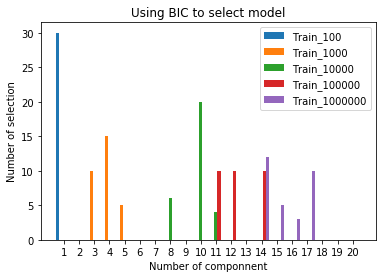

In [839]:
Train_100 = BICComponentSelectTime_100
Train_1000 = BICComponentSelectTime_1000
Train_10000 = BICComponentSelectTime_10000
Train_100000 = BICComponentSelectTime_100000
Train_1000000 = BICComponentSelectTime_1000000

x = np.arange(len(x_list))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
#fig.figure(figsize=(20,20))
ax.bar(x - 0.4, Train_100, width, label = 'Train_100')
ax.bar(x - 0.2, Train_1000, width, label = 'Train_1000')
ax.bar(x + 0, Train_10000, width, label = 'Train_10000')
ax.bar(x + 0.2, Train_100000, width, label = 'Train_100000')
ax.bar(x + 0.4, Train_1000000, width, label = 'Train_1000000')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of selection')
ax.set_xlabel('Number of componnent')
ax.set_title('Using BIC to select model')
ax.set_xticks(x)
ax.set_xticklabels(x_list)
ax.legend()

## k - fold

In [683]:
def k_fold(dataset, k):
    data_size = len(dataset)
    step = data_size // k
    index = np.arange(k) * step
    for i in range(k):
        val_index = np.arange(index[i], index[i] + step)
        train_index = list(set(range(data_size)).difference(val_index))
        yield dataset[train_index], dataset[val_index]

In [684]:
data_test = np.random.rand(100,3)
for train_test, val_test in k_fold(data_test, 10):
    pass

In [736]:
!python test_kfold.py

Size 100000 begin training ...... DONE! (1215.75 mins)
Size 100000 begin stroing ...... DONE!


In [767]:
with open('./test_result/kfold_100_result.pkl', 'rb') as f:
    kfold_100 = pickle.load(f)

In [745]:
with open('./test_result/kfold_1000_result.pkl', 'rb') as a:
    kfold_1000 = pickle.load(a)

In [746]:
with open('./test_result/kfold_10000_result.pkl', 'rb') as b:
    kfold_10000 = pickle.load(b)

In [747]:
with open('./test_result/kfold_100000_result.pkl', 'rb') as c:
    kfold_100000 = pickle.load(c)

In [768]:
component_select_100 = []
for i in range(20):
    component_select_100.append(np.nanmean(np.array(kfold_100[i]),axis = 0).argmax()+1)

/Users/tmac/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until


In [791]:
ComponentSelectList_100 = component_select_100 + [2,3,3,2,3,2,3,2,2,2]
ComponentSelectTime_100 = ((np.arange(1,21).reshape(20,1) - np.array(ComponentSelectList_100).reshape(1,30)) == 0).sum(axis = 1)

In [748]:
component_select_1000_1 = []
for i in range(20):
    component_select_1000_1.append(np.nanmean(np.array(kfold_1000[i]),axis = 0).argmax()+1)

In [793]:
ComponentSelectList_1000 = component_select_1000 + component_select_1000_1
ComponentSelectTime_1000 = ((np.arange(1,21).reshape(20,1) - np.array(ComponentSelectList_1000).reshape(1,30)) == 0).sum(axis = 1)

In [758]:
component_select_10000_1 = []
for i in range(20):
    component_select_10000_1.append(np.nanmean(np.array(kfold_10000[i]),axis = 0).argmax()+1)

In [796]:
ComponentSelectList_10000 = component_select_10000 + component_select_10000_1
ComponentSelectTime_10000 = ((np.arange(1,21).reshape(20,1) - np.array(ComponentSelectList_10000).reshape(1,30)) == 0).sum(axis = 1)

In [764]:
component_select_100000_1 = []
for i in range(20):
    component_select_100000_1.append(np.nanmean(np.array(kfold_100000[i]),axis = 0).argmax()+1)

In [797]:
ComponentSelectList_100000 = component_select_100000 + component_select_100000_1
ComponentSelectTime_100000 = ((np.arange(1,21).reshape(20,1) - np.array(ComponentSelectList_100000).reshape(1,30)) == 0).sum(axis = 1)

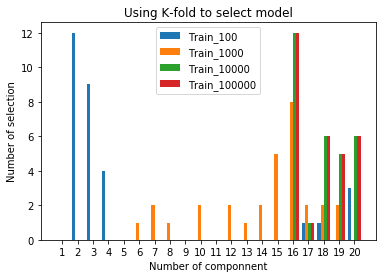

In [801]:
Trainset_100 = ComponentSelectTime_100
Trainset_1000 = ComponentSelectTime_1000
Trainset_10000 = ComponentSelectTime_10000
Trainset_100000 = ComponentSelectTime_10000

x = np.arange(len(x_list))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
#fig.figure(figsize=(20,20))
ax.bar(x - 0.3, Trainset_100, width, label = 'Train_100')
ax.bar(x - 0.1, Trainset_1000, width, label = 'Train_1000')
ax.bar(x + 0.1, Trainset_10000, width, label = 'Train_10000')
ax.bar(x + 0.3, Trainset_100000, width, label = 'Train_100000')


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number of selection')
ax.set_xlabel('Number of componnent')
ax.set_title('Using K-fold to select model')
ax.set_xticks(x)
ax.set_xticklabels(x_list)
ax.legend()